In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style
from collections import Counter
# from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)

In [27]:
import os

#Change the current working directory
os.chdir('E:/MSDSM/Sem-2/Data_Mining/Assignment-2/ml-latest-small/ml-latest-small')

#print the current working directory to confirm the change
print("Current Working Directory: ", os.getcwd())


Current Working Directory:  E:\MSDSM\Sem-2\Data_Mining\Assignment-2\ml-latest-small\ml-latest-small


In [28]:
movies_df = pd.read_csv('movies.csv')
links_df = pd.read_csv('links.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')

In [29]:
print(tags_df.columns)


Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')


In [30]:
number_of_ratings = len(ratings_df)
number_of_movies = len(ratings_df['movieId'].unique())
number_of_users = len(ratings_df['userId'].unique())

print(f"Total Number of ratings: {number_of_ratings}")
print(f"Number of unique movieId's: {number_of_movies}")
print(f"Number of unique users: {number_of_users}")
print(f"Average ratings per user: {round(number_of_ratings/number_of_users, 2)}")
print(f"Average ratings per movie: {round(number_of_ratings/number_of_movies, 2)}")


Total Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [31]:
user_freq = ratings_df[['userId', 'movieId']].groupby(
	'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head())


   userId  n_ratings
0       1        232
1       2         29
2       3         39
3       4        216
4       5         44


In [32]:
# Merge df1, df2, df3, and df4 on 'movieId'
joined_df = pd.merge(movies_df, links_df, on='movieId', how='outer').merge(ratings_df, on='movieId', how='outer').merge(tags_df, on='movieId', how='outer')
joined_df.head()

,movieId,title,genres,imdbId,tmdbId,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1.0,4.0,964982703.0,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1.0,4.0,964982703.0,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1.0,4.0,964982703.0,567.0,fun,1.525286e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,5.0,4.0,847434962.0,336.0,pixar,1.139046e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,5.0,4.0,847434962.0,474.0,pixar,1.137207e+09


In [33]:
import plotly.express as px

# Count tag frequencies
tag_counts = tags_df['tag'].value_counts()

# Get the top 20 most frequent tags
top_tags = tag_counts.head(20)

# Create a bar plot
fig = px.bar(x=top_tags.index, y=top_tags.values, labels={'x': 'Tags', 'y': 'Frequency'},
             title='Top 20 Tag Frequencies')
fig.update_xaxes(tickangle=45, tickfont=dict(size=10), title_text='')
fig.show()

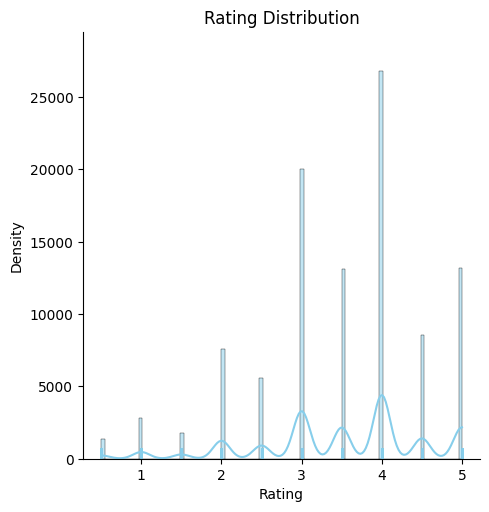

In [34]:

# Create a rating distribution plot
sns.displot(ratings_df['rating'], kde=True, color='skyblue', rug=True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()


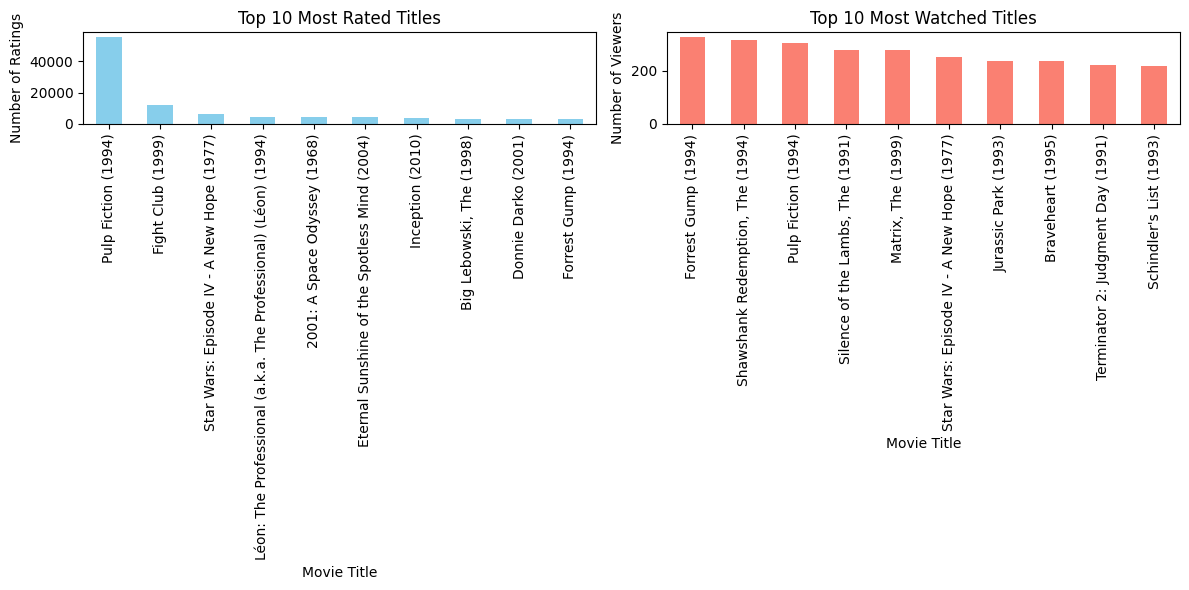

In [35]:
# Top 10 most rated titles
top_rated_titles = joined_df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

# Top 10 most watched titles
top_watched_titles = joined_df.groupby('title')['userId_x'].nunique().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 6))

# Top 10 most rated titles
plt.subplot(1, 2, 1)
top_rated_titles.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Rated Titles')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')

# Top 10 most watched titles
plt.subplot(1, 2, 2)
top_watched_titles.plot(kind='bar', color='salmon')
plt.title('Top 10 Most Watched Titles')
plt.xlabel('Movie Title')
plt.ylabel('Number of Viewers')

plt.tight_layout()
plt.show()

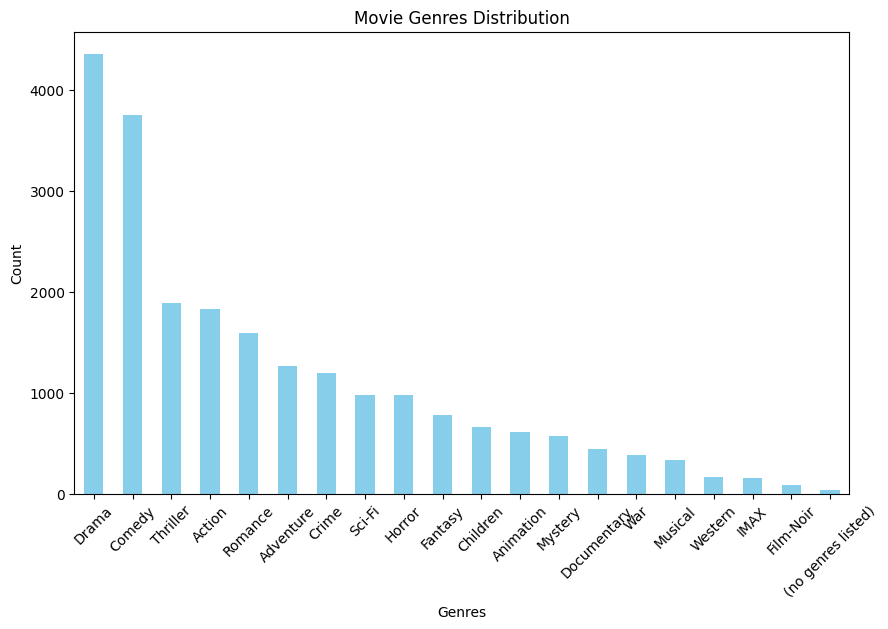

In [36]:
# Extract genres and count occurrences
genres_count = movies_df['genres'].str.split('|', expand=True).stack().value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
genres_count.plot(kind='bar', color='skyblue')
plt.title('Movie Genres Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [37]:
import plotly.graph_objects as go
# Calculate average rating per movie
avg_rating = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Calculate count of ratings per movie
rating_count = ratings_df['movieId'].value_counts().reset_index()
rating_count.columns = ['movieId', 'rating_count']

# Calculate count of tags per movie
tag_count = tags_df['movieId'].value_counts().reset_index()
tag_count.columns = ['movieId', 'tag_count']

# Merge the DataFrames
joined_data = pd.merge(movies_df, avg_rating, on='movieId', how='left')
joined_data = pd.merge(joined_data, rating_count, on='movieId', how='left')
joined_data = pd.merge(joined_data, tag_count, on='movieId', how='left')

# Find movie with the highest rating
highest_rated_movie = joined_data.loc[joined_data['rating'].idxmax()]

# Find most rated movie
most_rated_movie = joined_data.loc[joined_data['rating_count'].idxmax()]

# Find most watched movie
most_watched_movie = joined_data.loc[joined_data['tag_count'].idxmax()]

# Create a bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=[highest_rated_movie['title']], y=[highest_rated_movie['rating']], name='Highest Rating', marker_color='rgb(55, 83, 109)'))
fig.add_trace(go.Bar(x=[most_rated_movie['title']], y=[most_rated_movie['rating_count']], name='Most Rated', marker_color='rgb(26, 118, 255)'))
fig.add_trace(go.Bar(x=[most_watched_movie['title']], y=[most_watched_movie['tag_count']], name='Most Watched', marker_color='rgb(255, 71, 26)'))

fig.update_layout(title='Comparison of Movies',
                  xaxis_title='Movie',
                  yaxis_title='Value',
                  barmode='group')
fig.show()

In [38]:
# Find Lowest and Highest rated movies:
mean_rating = ratings_df.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies_df.loc[movies_df['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies_df.loc[movies_df['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings_df[ratings_df['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings_df[ratings_df['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings_df.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()


In [39]:
merged_df1 = pd.merge(movies_df, tags_df.groupby('movieId')['tag'].agg(lambda x: '|'.join(x)).reset_index(), on='movieId', how='left')
merged_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   tag      1572 non-null   object
dtypes: int64(1), object(3)
memory usage: 304.6+ KB


In [40]:
merged_df1['tag'] = merged_df1['tag'].fillna('No tags available')

In [41]:
# Group ratings by movieId and userId, concatenating all ratings into a single string
ratings_agg = ratings_df.groupby(['movieId', 'userId'])['rating'].agg(lambda x: '|'.join(map(str, x))).reset_index()

# Merge merged_df with ratings_agg to combine ratings for each movieId
merged_df = pd.merge(merged_df1, ratings_agg.pivot(index='movieId', columns='userId', values='rating'), on='movieId', how='left')


In [42]:
merged_df.isnull().sum()


movieId       0
title         0
genres        0
tag           0
1          9510
           ... 
606        8627
607        9555
608        8911
609        9705
610        8440
Length: 614, dtype: int64

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Columns: 614 entries, movieId to 610
dtypes: int64(1), object(613)
memory usage: 45.6+ MB


In [44]:
merged_df['tag']

0                                    pixar|pixar|fun
1       fantasy|magic board game|Robin Williams|game
2                                          moldy|old
3                                  No tags available
4                                   pregnancy|remake
                            ...                     
9737                               No tags available
9738                               No tags available
9739                               No tags available
9740                               No tags available
9741                               No tags available
Name: tag, Length: 9742, dtype: object

In [45]:
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(merged_df['tag'])

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert tfidf_matrix to a sparse matrix representation
tfidf_sparse = tfidf_matrix.tocsr()

# Compute cosine similarity using sparse matrix
cosine_sim = cosine_similarity(tfidf_sparse, tfidf_sparse)


In [47]:
indices=pd.Series(merged_df.index, index=merged_df['title']).drop_duplicates()

In [48]:
indices

title
Toy Story (1995)                                0
Jumanji (1995)                                  1
Grumpier Old Men (1995)                         2
Waiting to Exhale (1995)                        3
Father of the Bride Part II (1995)              4
                                             ... 
Black Butler: Book of the Atlantic (2017)    9737
No Game No Life: Zero (2017)                 9738
Flint (2017)                                 9739
Bungo Stray Dogs: Dead Apple (2018)          9740
Andrew Dice Clay: Dice Rules (1991)          9741
Length: 9742, dtype: int64

In [49]:
def get_recommendation(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    print(movies_df['title'].iloc[movie_indices])
movie_name=input("Enter the movie name: ")
print("The Input name is: ", movie_name)
get_recommendation(movie_name)

The Input name is:  Toy Story (1995)
1757                Bug's Life, A (1998)
2355                  Toy Story 2 (1999)
8695    Guardians of the Galaxy 2 (2017)
7039                           Up (2009)
8546                   Big Hero 6 (2014)
8357               The Lego Movie (2014)
7693                Avengers, The (2012)
257                  Pulp Fiction (1994)
1                         Jumanji (1995)
2                Grumpier Old Men (1995)
Name: title, dtype: object
